<a href="https://colab.research.google.com/github/DJCordhose/ml-workshop/blob/master/notebooks/intro/nn-03-regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regularization Techniques

_Challenge: We know we have a linear problem, but neural networks predict a very complex decision boundary. This is called overfitting_

Techniques to fight overfitting are called regularization
1. simplify model
1. early stopping
1. use simple SGD optimizer
1. add classic L1/L2 regularization
1. dropout and batch normalization
1. use selu activation and alpha dropout

Bouns: increase batch size


In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
tf.__version__

TensorFlow 2.x selected.


'2.1.0'

In [0]:
tf.random.set_seed(42)

In [3]:
!nvidia-smi

Fri Feb 28 17:04:31 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# used to find good parameters for classic l1/l2
!pip install -q keras-tuner

In [0]:
# https://github.com/AndreasMadsen/python-lrcurve
!pip install -q lrcurve

In [0]:
from lrcurve import KerasLearningCurve

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 8)
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 20

figsize_3d = (12, 12)

In [0]:
# Adapted from:
# http://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
# http://jponttuset.cat/xkcd-deep-learning/

from matplotlib.colors import ListedColormap

import numpy as np
import pandas as pd

cmap = ListedColormap(['#FF6666', '#6666FF'])

font_size=15
title_font_size=25

def meshGrid(x_data, y_data):
    h = .05  # step size in the mesh
#     x_min, x_max = -0.1, 1.1
#     y_min, y_max = -0.1, 1.1

    x_min, x_max = x_data.min() - .1, x_data.max() + .1
    y_min, y_max = y_data.min() - .1, y_data.max() + .1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return (xx,yy)
    
def plotPrediction(clf, x_data, y_data, x_label, y_label, ground_truth, title="", 
                   size=(15, 8), n_samples=None, proba=True, prediction=True, 
                   ax=None, marker_size=100
                  ):
    xx,yy = meshGrid(x_data, y_data)
    if ax is None:
      _, ax = plt.subplots(figsize=size)

    if clf:
        Z = clf.predict_proba(np.c_[yy.ravel(), xx.ravel()])
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=.6)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    
    samples = pd.DataFrame(np.array([x_data, y_data, ground_truth]).T)
    if n_samples:
      samples = samples.sample(n_samples, random_state=42)
      
    classes = samples[2]
    ax.scatter(samples[0], samples[1], c=classes, cmap=cmap, marker='o', edgecolors='k', s=classes*marker_size)
    ax.scatter(samples[0], samples[1], c=classes, cmap=cmap, marker='^', edgecolors='k', s=~classes.astype(bool)*marker_size)

    ax.set_xlabel(x_label, fontsize=font_size)
    ax.set_ylabel(y_label, fontsize=font_size)
    ax.set_title(title, fontsize=title_font_size)

    return ax


## binary classification - We only have two categories (0/1 or red/blue)

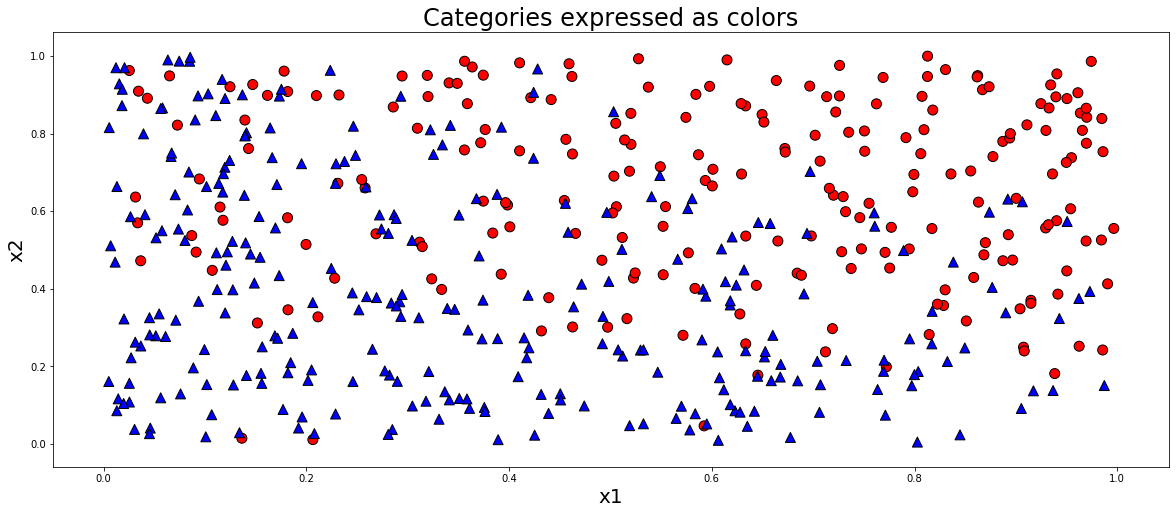

In [10]:
#@title Configure our example { run: "auto", display-mode: "form" }

# https://colab.research.google.com/notebooks/forms.ipynb

n = 500 #@param {type:"slider", min:1, max:5000, step:1}
m = -1 #@param {type:"slider", min:-10, max:10, step: 0.1}
b = 1 #@param {type:"slider", min:-10, max:10, step: 0.1}

noise_level = 0.4 #@param {type:"slider", min:0.1, max:1.0, step:0.1}

title = 'Categories expressed as colors' #@param {type:"string"}
dim_1_label = 'x1' #@param {type:"string"}
dim_2_label = 'x2' #@param {type:"string"}

import numpy as np
np.random.seed(42)

# all points
X = np.random.uniform(0, 1, (n, 2))

# below or above line determines which category they belong to (plus noise)
noise = np.random.normal(0, noise_level, n)
y_bool = X[:, 1] > m*X[:, 0]+b + noise
y = y_bool.astype(int)

plt.xlabel(dim_1_label)
plt.ylabel(dim_2_label)
plt.title(title)

size=100

plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.bwr, marker='o', edgecolors='k', s=y*size);
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.bwr, marker='^', edgecolors='k', s=~y_bool*size);

### We have two dimensions as input now

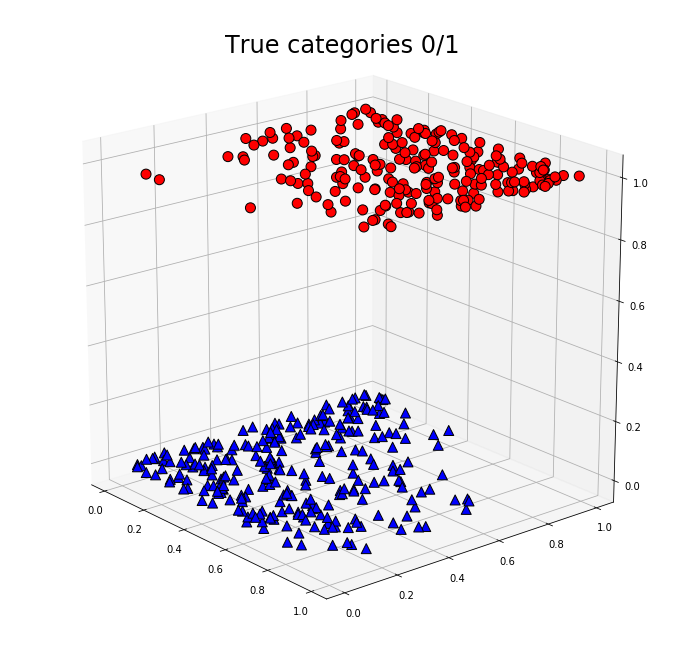

In [11]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=figsize_3d)

ax = fig.add_subplot(111, projection='3d')
ax.set_title('True categories 0/1')

# we can have the probability encoded in shade of color
ax.scatter(X[:,0], X[:,1], y, c=y, 
           cmap=plt.cm.bwr,
           marker='o', 
           edgecolors='k',
           depthshade=False,
           s=y*size)

ax.scatter(X[:,0], X[:,1], y, c=y, 
           cmap=plt.cm.bwr,
           marker='^', 
           edgecolors='k',
           depthshade=False,
           s=~y_bool*size)

# https://en.wikipedia.org/wiki/Azimuth
ax.view_init(elev=20, azim=-40)

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((400, 2), (100, 2), (400,), (100,))

# The issue: Overfitting

In [13]:
%%time 
 
EPOCHS=1000    

optimizer = tf.keras.optimizers.Adam()     

from tensorflow.keras.layers import Dense    

model = tf.keras.Sequential()
model.add(Dense(units=100, input_dim=2, activation='relu'))
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer=optimizer,
             metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=EPOCHS, 
                    callbacks=[KerasLearningCurve()],
                    verbose=0)

CPU times: user 1min, sys: 5.6 s, total: 1min 5s
Wall time: 50.8 s


In [14]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=0)
loss, accuracy

(0.3386331081390381, 0.8475)

In [15]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
loss, accuracy

(0.5231755399703979, 0.71)

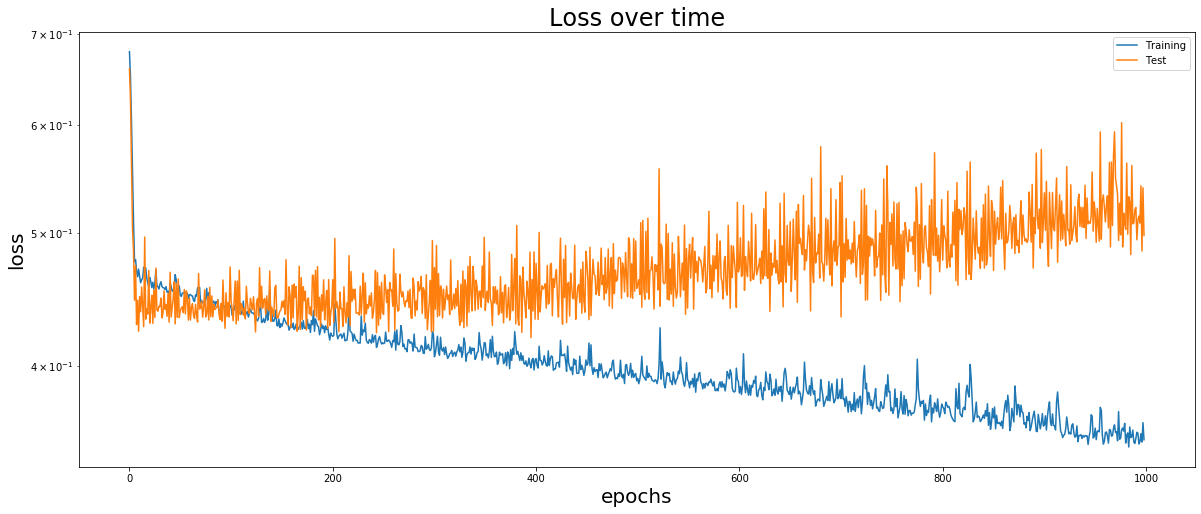

In [16]:
START_EPOCHE = 0
END_EPOCHE = -1

plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title('Loss over time')

plt.plot(history.history['loss'][START_EPOCHE:END_EPOCHE]);
plt.plot(history.history['val_loss'][START_EPOCHE:END_EPOCHE]);

plt.legend(['Training', 'Test']);

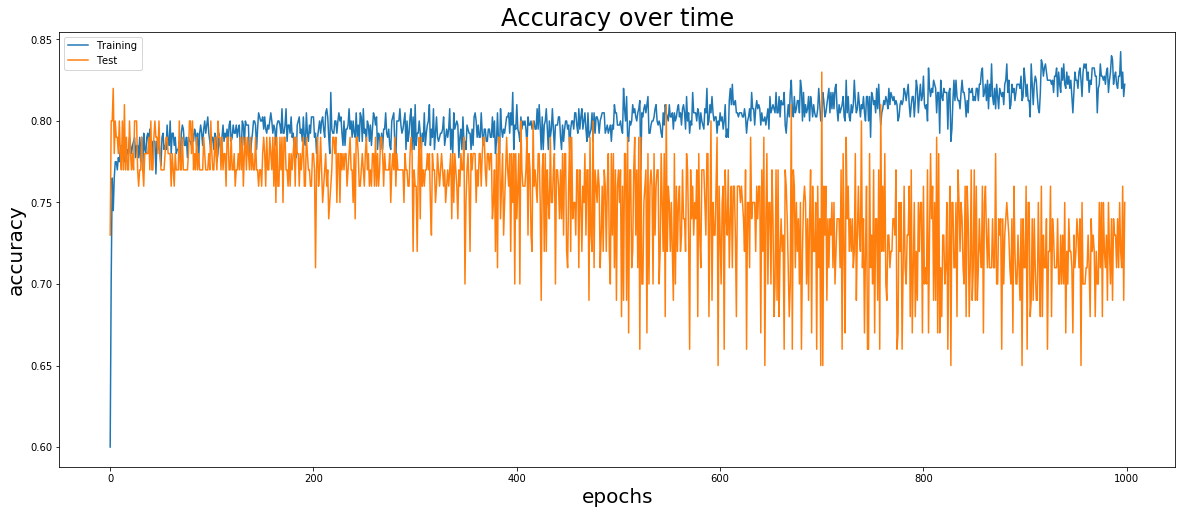

In [17]:
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.title('Accuracy over time')

plt.plot(history.history['accuracy'][START_EPOCHE:END_EPOCHE])
plt.plot(history.history['val_accuracy'][START_EPOCHE:END_EPOCHE])

plt.legend(['Training', 'Test']);

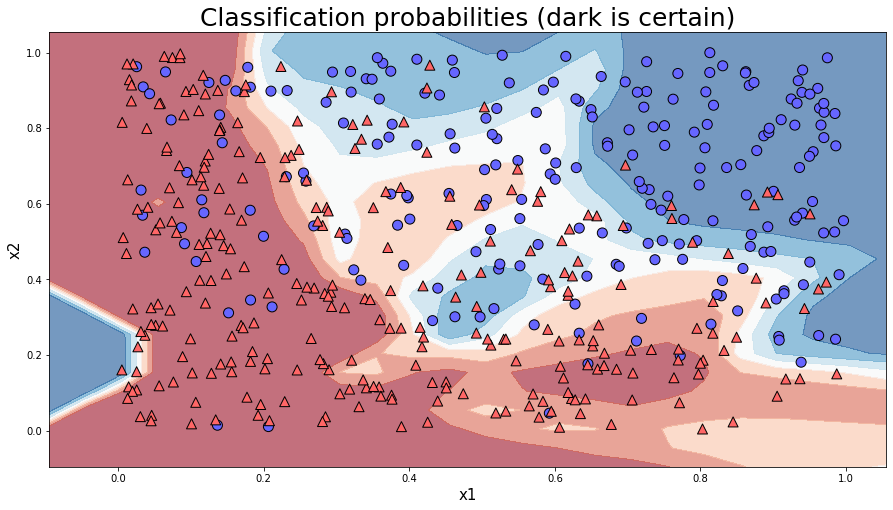

In [18]:
plotPrediction(model, X[:, 0], X[:, 1], 
               dim_1_label, dim_2_label, y,
                title="Classification probabilities (dark is certain)");

# Approach 0: Large Batch Size

***intuition: do not allow model to overfit on single data points, because update will be for all data points at the same time***

often doesn't work too well and sometimes is not feasiable because of limited memory on GPU

In [19]:
%%time 

EPOCHS=1000
# BATCH_SIZE=32 # default
BATCH_SIZE=500 # basically all the data

optimizer = tf.keras.optimizers.Adam()     

from tensorflow.keras.layers import Dense    
    
model = tf.keras.Sequential()
model.add(Dense(units=100, input_dim=2, activation='relu'))
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer=optimizer,
             metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=EPOCHS, 
                    callbacks=[KerasLearningCurve()],
                    batch_size=BATCH_SIZE, 
                    verbose=0)

CPU times: user 11.9 s, sys: 1.04 s, total: 12.9 s
Wall time: 12.5 s


In [20]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=0)
loss, accuracy

(0.37799639701843263, 0.8125)

In [21]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
loss, accuracy

(0.4763548493385315, 0.73)

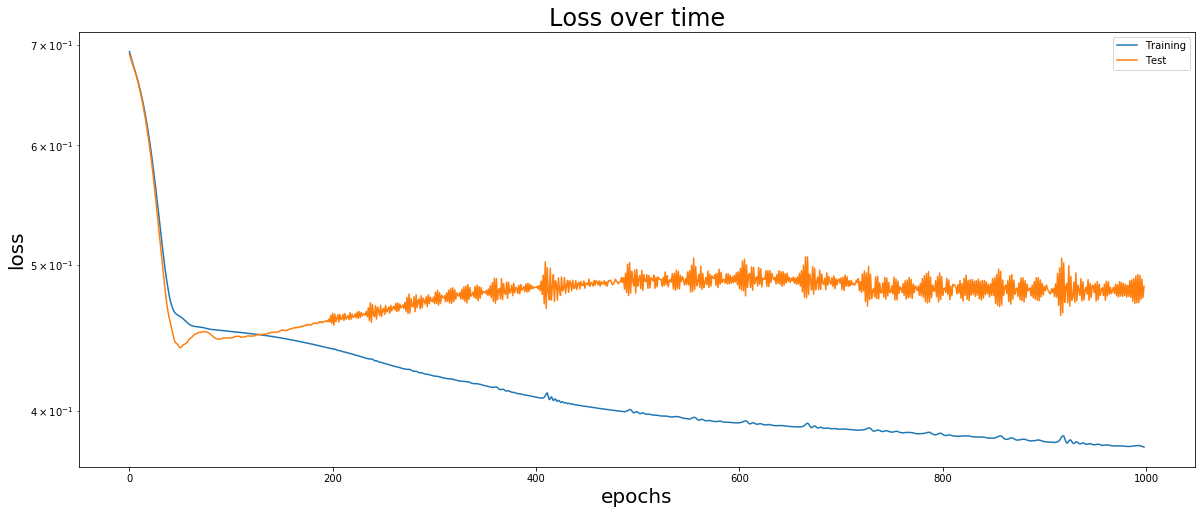

In [22]:
START_EPOCHE = 0
END_EPOCHE = -1

plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title('Loss over time')

plt.plot(history.history['loss'][START_EPOCHE:END_EPOCHE]);
plt.plot(history.history['val_loss'][START_EPOCHE:END_EPOCHE]);

plt.legend(['Training', 'Test']);

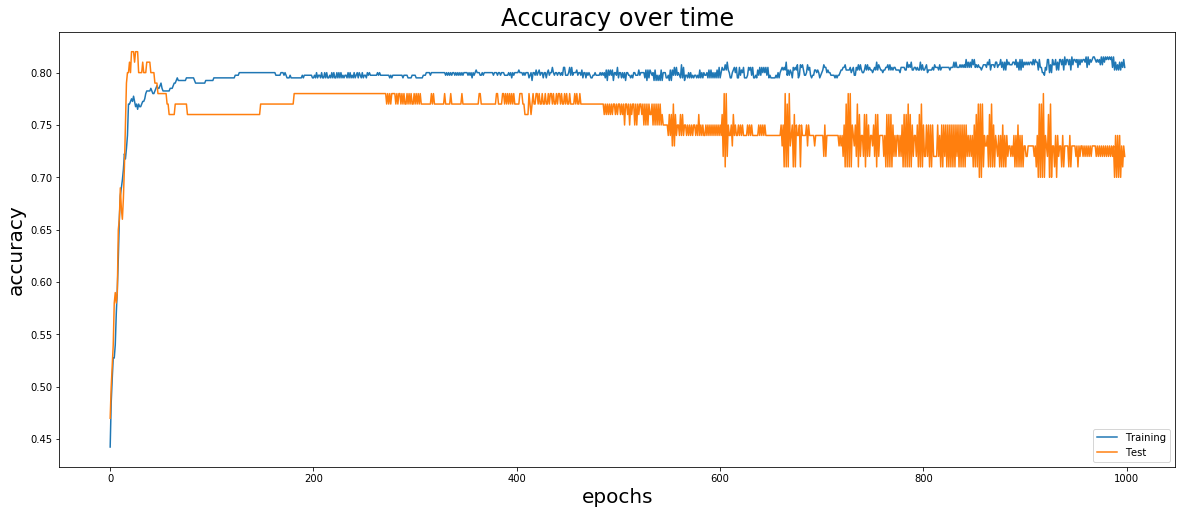

In [23]:
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.title('Accuracy over time')

plt.plot(history.history['accuracy'][START_EPOCHE:END_EPOCHE])
plt.plot(history.history['val_accuracy'][START_EPOCHE:END_EPOCHE])

plt.legend(['Training', 'Test']);

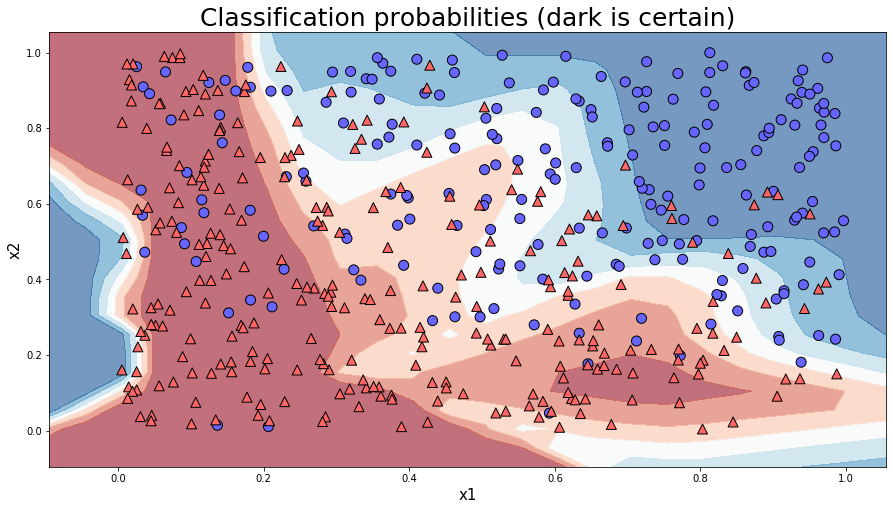

In [24]:
plotPrediction(model, X[:, 0], X[:, 1], 
               dim_1_label, dim_2_label, y,
                title="Classification probabilities (dark is certain)");

# Approach I: Simple model

***intuition: restrict model by simplicity, do not give it enough capacity to overfit***

might instead cause underfitting


In [25]:
%%time 
 
EPOCHS=1000    
# learning_rate=1e-4
learning_rate=1e-3 #DEFAULT
# learning_rate=1e-2

from tensorflow.keras.layers import Dense    
    
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)     
    
model = tf.keras.Sequential()
model.add(Dense(units=1, input_dim=2, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer=optimizer,
             metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=EPOCHS, 
                    callbacks=[KerasLearningCurve()],
                    verbose=0)

CPU times: user 55.4 s, sys: 5.06 s, total: 1min
Wall time: 46.1 s


In [26]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=0)
loss, accuracy

(0.4747112584114075, 0.785)

In [27]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
loss, accuracy

(0.48941883325576785, 0.81)

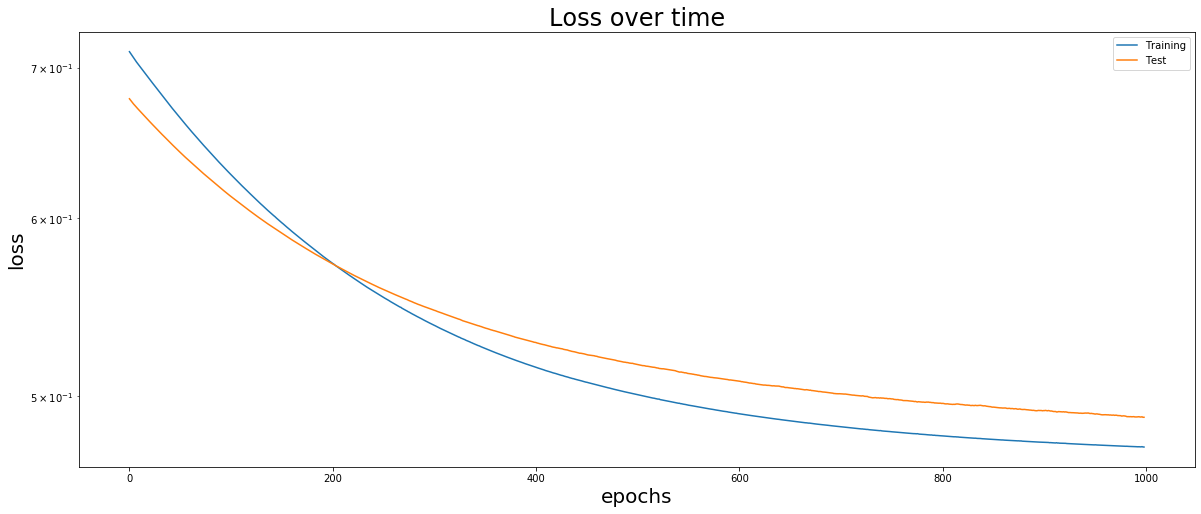

In [28]:
START_EPOCHE = 0
END_EPOCHE = -1

plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title('Loss over time')

plt.plot(history.history['loss'][START_EPOCHE:END_EPOCHE]);
plt.plot(history.history['val_loss'][START_EPOCHE:END_EPOCHE]);

plt.legend(['Training', 'Test']);

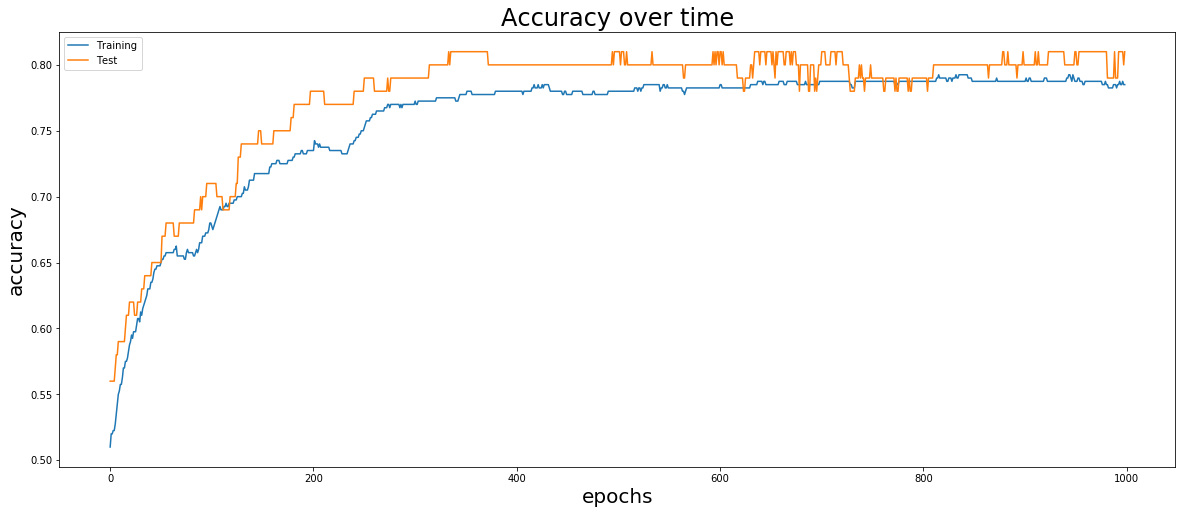

In [29]:
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.title('Accuracy over time')

plt.plot(history.history['accuracy'][START_EPOCHE:END_EPOCHE])
plt.plot(history.history['val_accuracy'][START_EPOCHE:END_EPOCHE])

plt.legend(['Training', 'Test']);

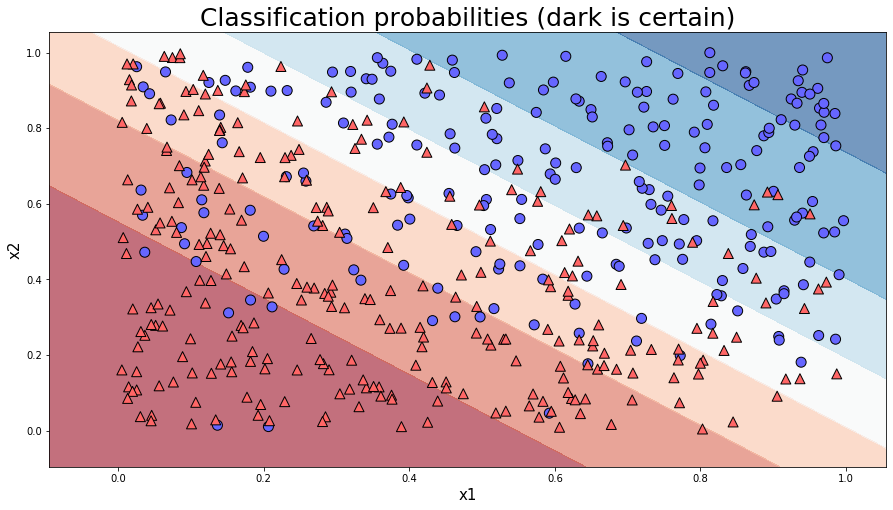

In [30]:
plotPrediction(model, X[:, 0], X[:, 1], 
               dim_1_label, dim_2_label, y,
                title="Classification probabilities (dark is certain)");

# Approach II: Early Stopping

***intuition: stop training once the model starts to overfit***

will not work if the model starts overfitting right from the start

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

In [31]:
%%time 
 
EPOCHS=1000    
# learning_rate=1e-4
learning_rate=1e-3

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)     

PATIENCE = 10
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE)

from tensorflow.keras.layers import Dense    
    
model = tf.keras.Sequential()
model.add(Dense(units=100, input_dim=2, activation='relu'))
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer=optimizer,
             metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=EPOCHS, 
                    callbacks=[early_stopping_callback, KerasLearningCurve()],
                    verbose=0)

CPU times: user 1.73 s, sys: 85.7 ms, total: 1.81 s
Wall time: 1.57 s


In [32]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=0)
loss, accuracy

(0.45971528768539427, 0.775)

In [33]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
loss, accuracy

(0.47479660987854005, 0.8)

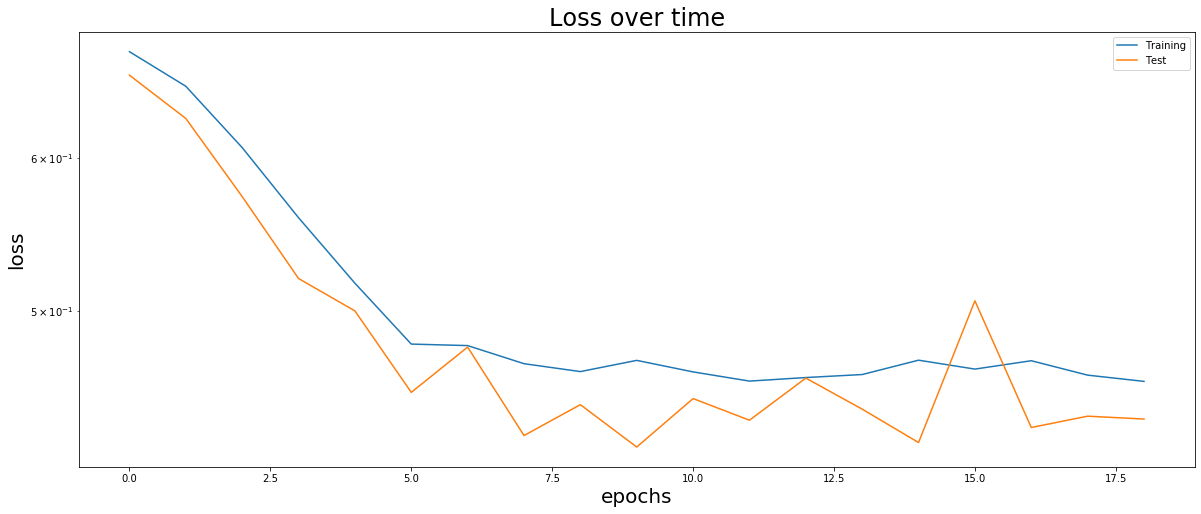

In [34]:
START_EPOCHE = 0
END_EPOCHE = -1

plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title('Loss over time')

plt.plot(history.history['loss'][START_EPOCHE:END_EPOCHE]);
plt.plot(history.history['val_loss'][START_EPOCHE:END_EPOCHE]);

plt.legend(['Training', 'Test']);

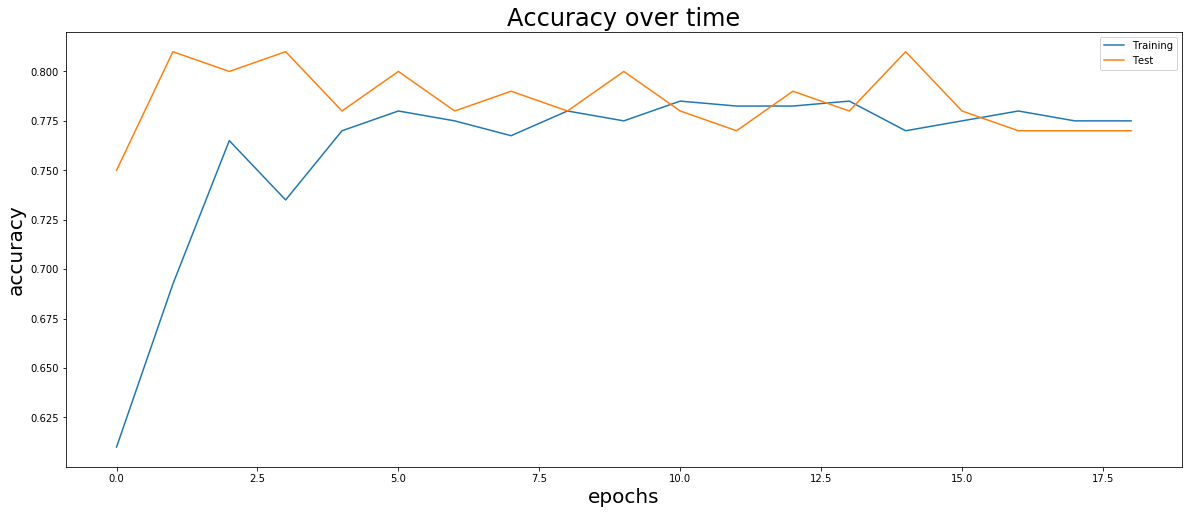

In [35]:
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.title('Accuracy over time')

plt.plot(history.history['accuracy'][START_EPOCHE:END_EPOCHE])
plt.plot(history.history['val_accuracy'][START_EPOCHE:END_EPOCHE])

plt.legend(['Training', 'Test']);

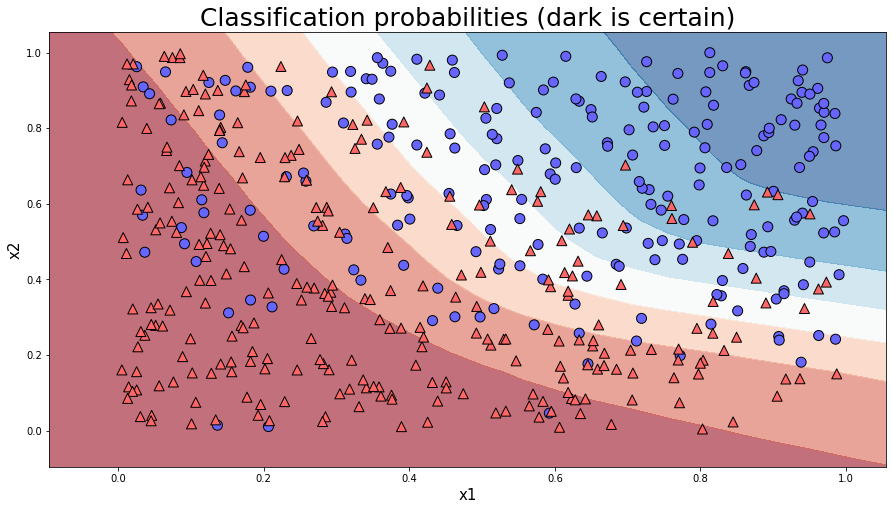

In [36]:
plotPrediction(model, X[:, 0], X[:, 1], 
               dim_1_label, dim_2_label, y,
                title="Classification probabilities (dark is certain)");

# Approach III: Use SGD

***intuition: SGD just is not smart enough to find a highly specific solution***

still takes a lot of time

In [37]:
%%time 
 
EPOCHS=1000    
# learning_rate=1e-4
# learning_rate=1e-3
learning_rate=1e-2 #DEFAULT

from tensorflow.keras.layers import Dense    
    
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)     
    
model = tf.keras.Sequential()
model.add(Dense(units=100, input_dim=2, activation='relu'))
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer=optimizer,
             metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=EPOCHS, 
                    callbacks=[KerasLearningCurve()],
                    verbose=0)

CPU times: user 58 s, sys: 4.92 s, total: 1min 2s
Wall time: 48.8 s


In [38]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=0)
loss, accuracy

(0.45253337144851685, 0.795)

In [39]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
loss, accuracy

(0.44056718945503237, 0.76)

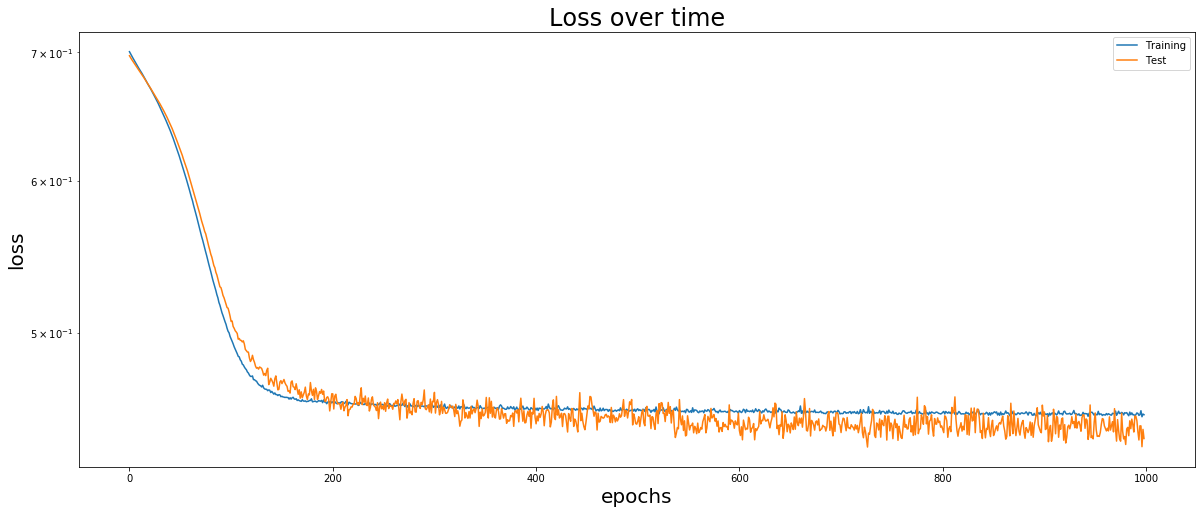

In [40]:
START_EPOCHE = 0
END_EPOCHE = -1

plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title('Loss over time')

plt.plot(history.history['loss'][START_EPOCHE:END_EPOCHE]);
plt.plot(history.history['val_loss'][START_EPOCHE:END_EPOCHE]);

plt.legend(['Training', 'Test']);

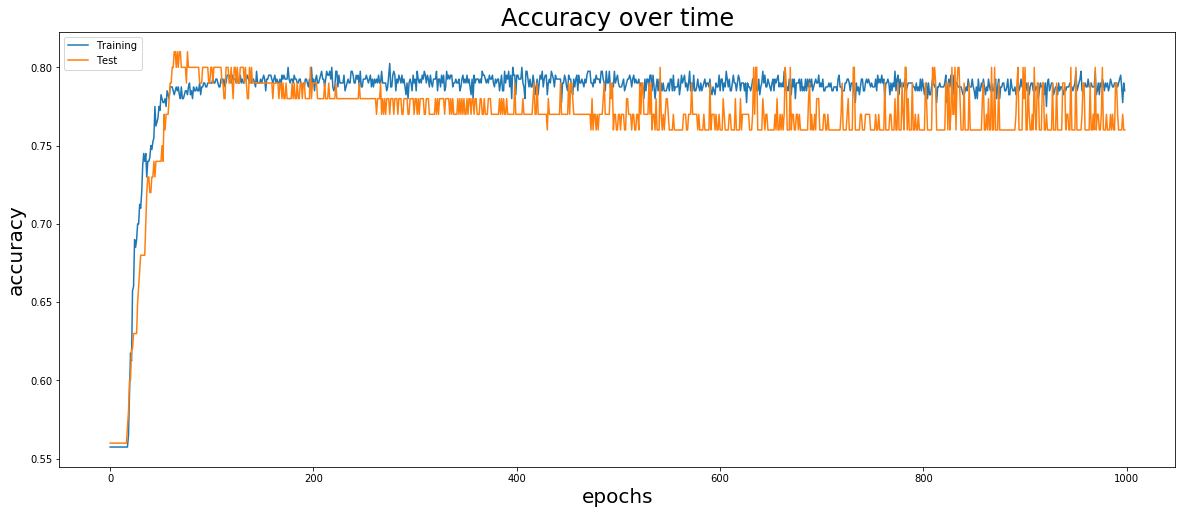

In [41]:
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.title('Accuracy over time')

plt.plot(history.history['accuracy'][START_EPOCHE:END_EPOCHE])
plt.plot(history.history['val_accuracy'][START_EPOCHE:END_EPOCHE])

plt.legend(['Training', 'Test']);

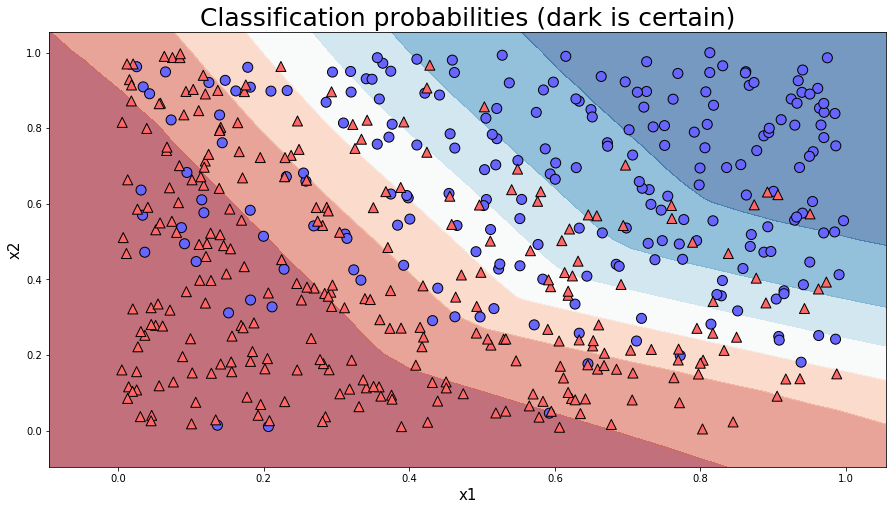

In [42]:
plotPrediction(model, X[:, 0], X[:, 1], 
               dim_1_label, dim_2_label, y,
                title="Classification probabilities (dark is certain)");

# Approach IV: classic L1/L2 regularization

***intuition: add a regularization term to the loss to restrict size of model parameters***

* l1 will bring down parameters to zero that are not so important
* l2 keeps parameters in a reasonable size

Finding right lambda parameters for l1 and l2 is needs experimentation

In [0]:
from tensorflow.keras.regularizers import l1, l2, l1_l2

## L1 plus early stopping

lambda determined by manual experiment

In [44]:
%%time 
 
EPOCHS=1000

l1 = .03
l2 = .0

optimizer = tf.keras.optimizers.Adam()     

from tensorflow.keras.layers import Dense
    
model = tf.keras.Sequential()
model.add(Dense(units=100, 
                input_dim=2, 
                activation='relu',
                activity_regularizer=l1_l2(l1=l1, l2=l2)))
model.add(Dense(units=100, 
                activation='relu',
                activity_regularizer=l1_l2(l1=l1, l2=l2)))
model.add(Dense(units=100, 
                activation='relu',
                activity_regularizer=l1_l2(l1=l1, l2=l2)))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer=optimizer,
             metrics=['accuracy'])

PATIENCE = 50
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE)

history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=EPOCHS, 
                    callbacks=[early_stopping_callback, KerasLearningCurve()],
                    verbose=0)

CPU times: user 19 s, sys: 1.73 s, total: 20.7 s
Wall time: 15.3 s


In [45]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=0)
loss, accuracy

(0.4657596015930176, 0.8025)

In [46]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
loss, accuracy

(0.48999551773071287, 0.78)

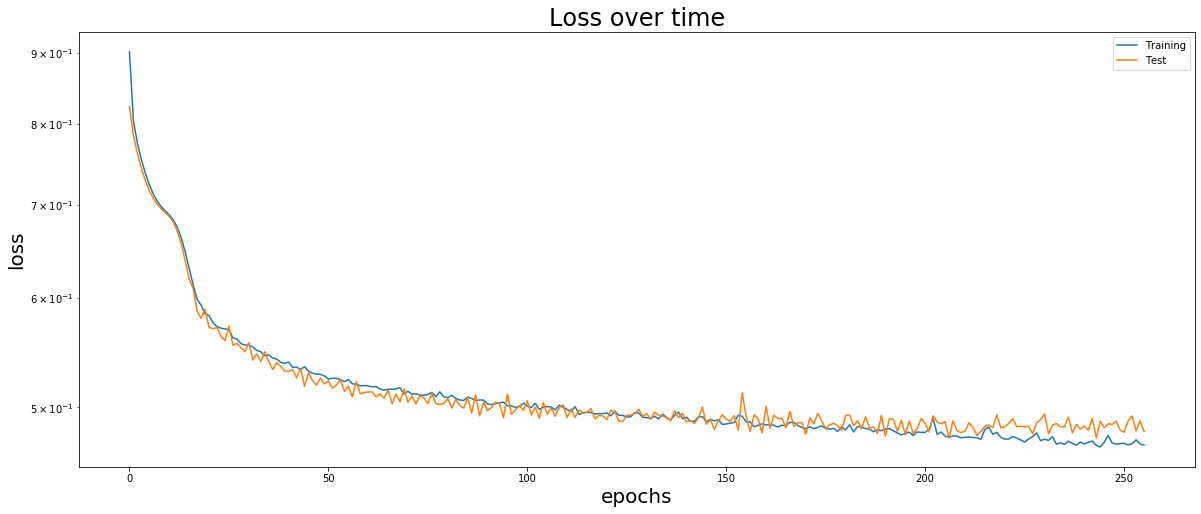

In [47]:
START_EPOCHE = 0
END_EPOCHE = -1

plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title('Loss over time')

plt.plot(history.history['loss'][START_EPOCHE:END_EPOCHE]);
plt.plot(history.history['val_loss'][START_EPOCHE:END_EPOCHE]);

plt.legend(['Training', 'Test']);

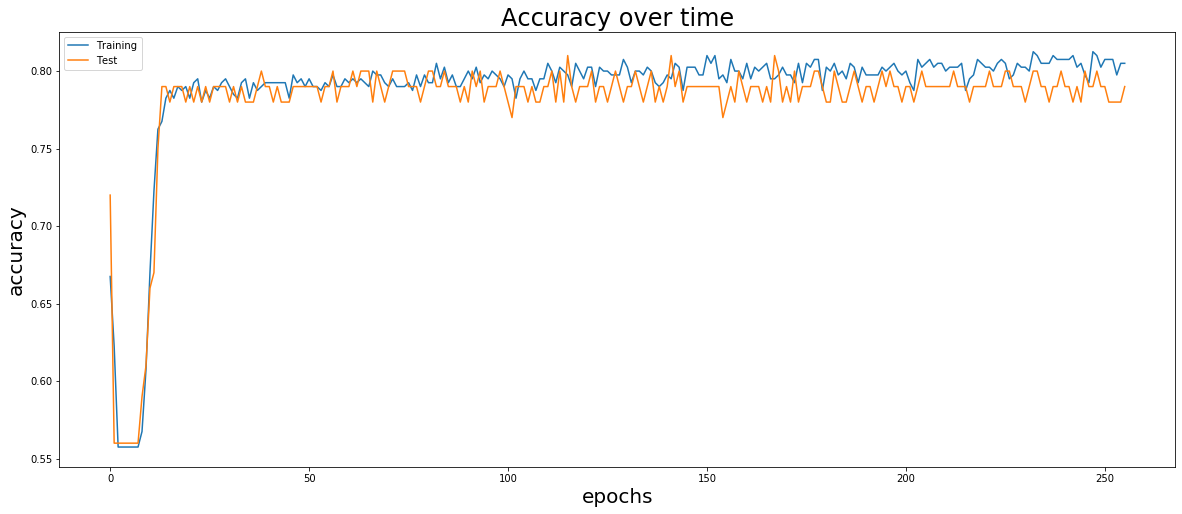

In [48]:
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.title('Accuracy over time')

plt.plot(history.history['accuracy'][START_EPOCHE:END_EPOCHE])
plt.plot(history.history['val_accuracy'][START_EPOCHE:END_EPOCHE])

plt.legend(['Training', 'Test']);

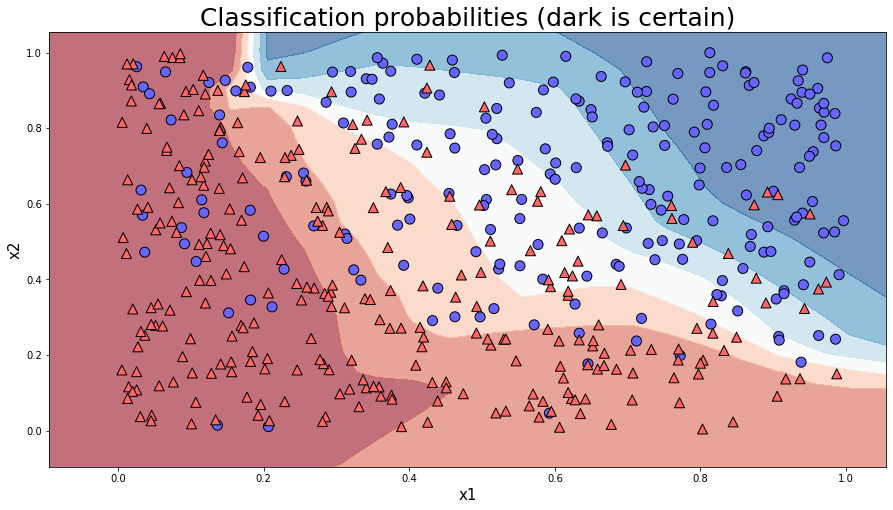

In [49]:
plotPrediction(model, X[:, 0], X[:, 1], 
               dim_1_label, dim_2_label, y,
                title="Classification probabilities (dark is certain)");

## L2 plus early stopping

lambda determined by manual experiment

In [50]:
%%time 
 
EPOCHS=1000

l1 = .0
l2 = 5

optimizer = tf.keras.optimizers.Adam()     

from tensorflow.keras.layers import Dense
    
model = tf.keras.Sequential()
model.add(Dense(units=100, 
                input_dim=2, 
                activation='relu',
                activity_regularizer=l1_l2(l1=l1, l2=l2)))
model.add(Dense(units=100, 
                activation='relu',
                activity_regularizer=l1_l2(l1=l1, l2=l2)))
model.add(Dense(units=100, 
                activation='relu',
                activity_regularizer=l1_l2(l1=l1, l2=l2)))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer=optimizer,
             metrics=['accuracy'])

PATIENCE = 50
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE)

history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=EPOCHS, 
                    callbacks=[early_stopping_callback, KerasLearningCurve()],
                    # callbacks=[KerasLearningCurve()],
                    verbose=0)

CPU times: user 41.9 s, sys: 4.12 s, total: 46 s
Wall time: 33.2 s


In [51]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=0)
loss, accuracy

(0.48570144414901734, 0.79)

In [52]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
loss, accuracy

(0.5042435145378112, 0.8)

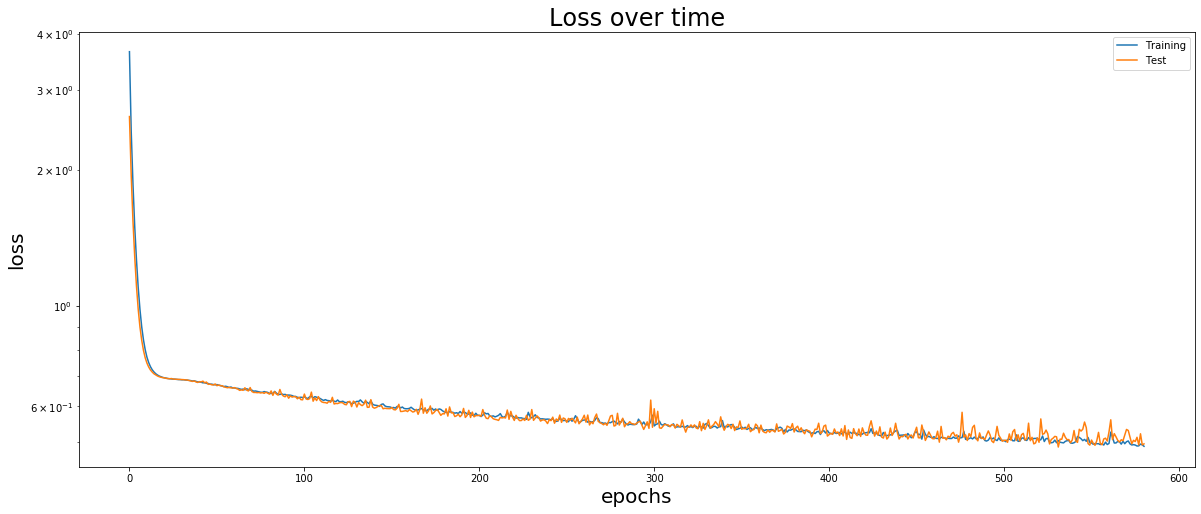

In [53]:
START_EPOCHE = 0
END_EPOCHE = -1

plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title('Loss over time')

plt.plot(history.history['loss'][START_EPOCHE:END_EPOCHE]);
plt.plot(history.history['val_loss'][START_EPOCHE:END_EPOCHE]);

plt.legend(['Training', 'Test']);

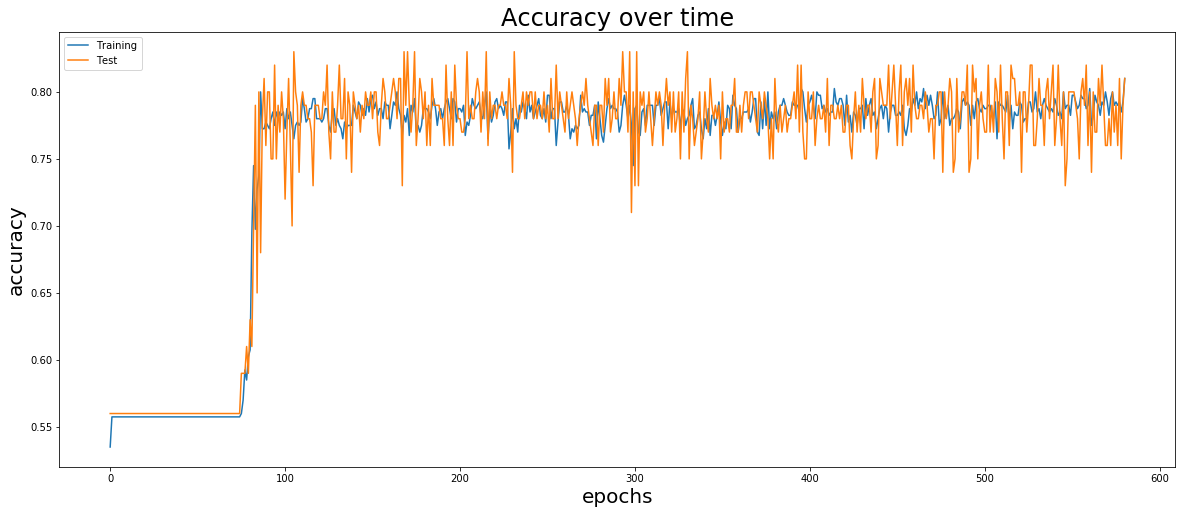

In [54]:
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.title('Accuracy over time')

plt.plot(history.history['accuracy'][START_EPOCHE:END_EPOCHE])
plt.plot(history.history['val_accuracy'][START_EPOCHE:END_EPOCHE])

plt.legend(['Training', 'Test']);

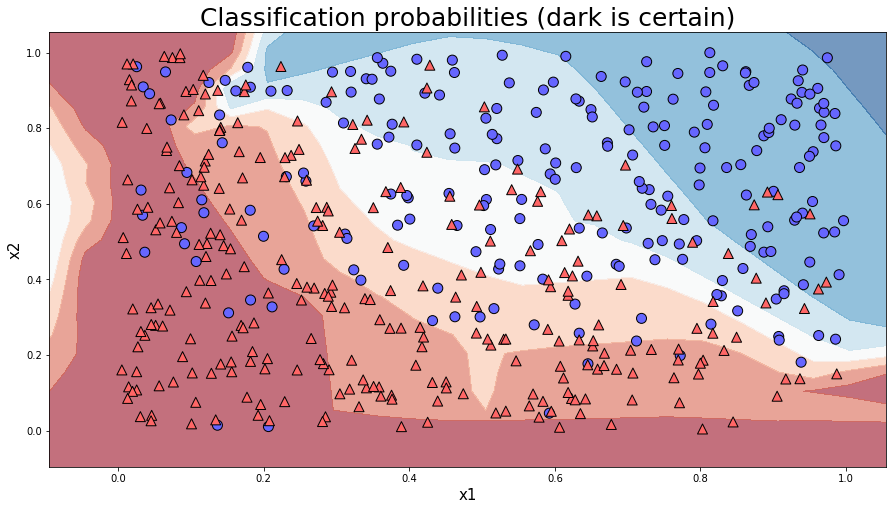

In [55]:
plotPrediction(model, X[:, 0], X[:, 1], 
               dim_1_label, dim_2_label, y,
                title="Classification probabilities (dark is certain)");

## L1 and L2 determined by Keras Tuner

* https://blog.tensorflow.org/2020/01/hyperparameter-tuning-with-keras-tuner.html
* https://github.com/keras-team/keras-tuner
* https://keras-team.github.io/keras-tuner/

In [56]:
!rm -r tuner

rm: cannot remove 'tuner': No such file or directory


In [57]:
%%time

from tensorflow import keras

from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch

class MyHyperModel(HyperModel):
    def __init__(self, num_layers):
        self.num_layers = num_layers

    def build(self, hp):
        model = keras.Sequential()
        l1 = hp.Float('l1', min_value=.0, max_value=.1)
        l2 = hp.Float('l2', min_value=.0, max_value=10.)

        model.add(Dense(units=100, 
                input_dim=2, 
                activation='relu',
                activity_regularizer=l1_l2(l1=l1, l2=l2)))

        for i in range(self.num_layers - 1):
          model.add(Dense(units=100, 
                  activation='relu',
                  activity_regularizer=l1_l2(l1=l1, l2=l2)))
        
        model.add(Dense(units=1, activation='sigmoid'))
        model.compile(
            optimizer=keras.optimizers.Adam(),
            loss='binary_crossentropy',
            metrics=['accuracy'])
        return model


hypermodel = MyHyperModel(num_layers=3)

tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=10,
    directory='tuner',
    project_name='binary')

tuner.search(X_train, y_train,
             epochs=100,
             validation_data=(X_test, y_test),
             verbose=0
             )

INFO:tensorflow:Oracle triggered exit
CPU times: user 1min 23s, sys: 8.14 s, total: 1min 32s
Wall time: 1min 5s


In [58]:
tuner.results_summary()

In [59]:
%%time 

model = tuner.get_best_models(num_models=1)[0]

EPOCHS=1000

PATIENCE = 50
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE)

history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=EPOCHS, 
                    callbacks=[early_stopping_callback, KerasLearningCurve()],
                    # callbacks=[KerasLearningCurve()],
                    verbose=0)

CPU times: user 22.2 s, sys: 2.27 s, total: 24.5 s
Wall time: 17.8 s


In [60]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=0)
loss, accuracy

(0.6865255451202392, 0.5575)

In [61]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
loss, accuracy

(0.6859707403182983, 0.56)

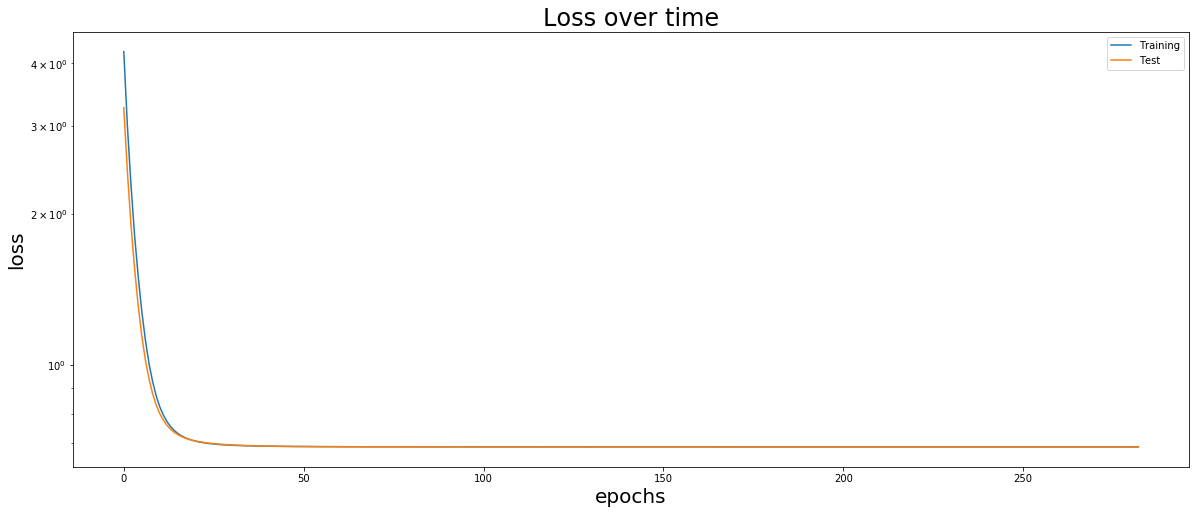

In [62]:
START_EPOCHE = 0
END_EPOCHE = -1

plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title('Loss over time')

plt.plot(history.history['loss'][START_EPOCHE:END_EPOCHE]);
plt.plot(history.history['val_loss'][START_EPOCHE:END_EPOCHE]);

plt.legend(['Training', 'Test']);

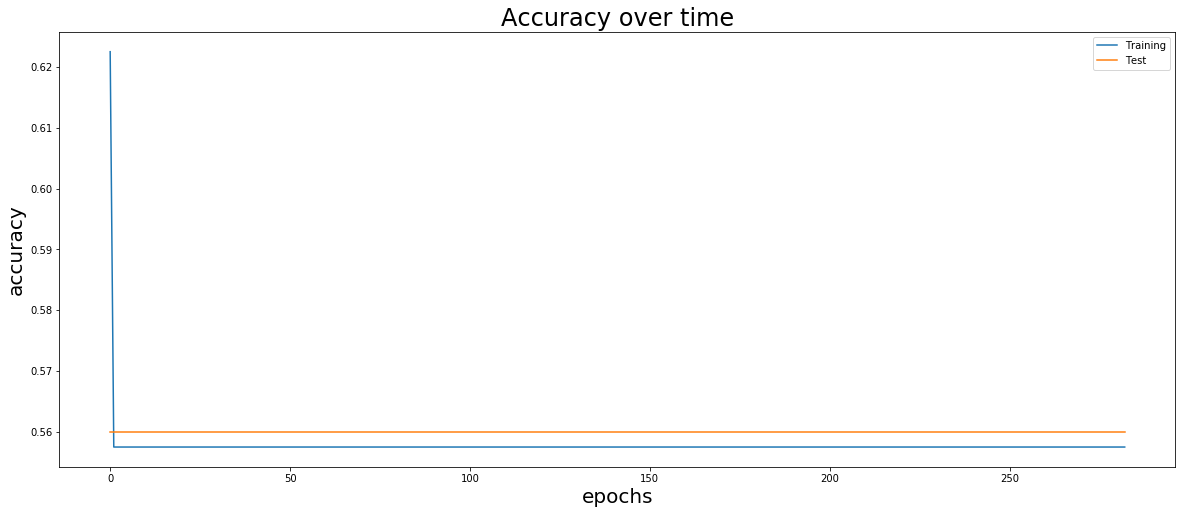

In [63]:
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.title('Accuracy over time')

plt.plot(history.history['accuracy'][START_EPOCHE:END_EPOCHE])
plt.plot(history.history['val_accuracy'][START_EPOCHE:END_EPOCHE])

plt.legend(['Training', 'Test']);

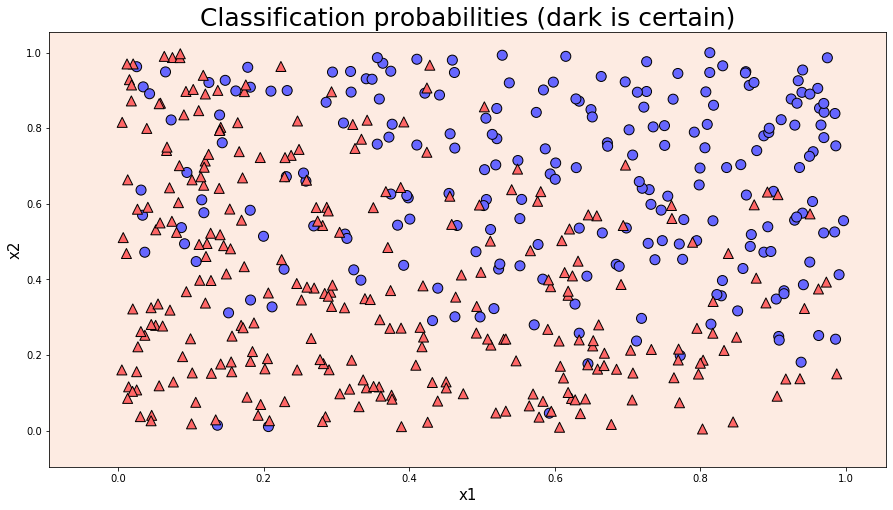

In [64]:
plotPrediction(model, X[:, 0], X[:, 1], 
               dim_1_label, dim_2_label, y,
                title="Classification probabilities (dark is certain)");

# Approach V: Dropout and Batch Normalization

***intuition: train a set of smaller neural networks and combine them again in an ensemble***

might still be the gold standard in combination with batch normalization and early stopping

In [65]:
%%time 
 
EPOCHS=1000    

dropout = 0.5

optimizer = tf.keras.optimizers.Adam()     

from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
    
model = tf.keras.Sequential()
model.add(Dense(units=100, input_dim=2, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Dense(units=100, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Dense(units=100, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer=optimizer,
             metrics=['accuracy'])

PATIENCE = 50
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE)

history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=EPOCHS, 
                    callbacks=[early_stopping_callback, KerasLearningCurve()],
                    # callbacks=[KerasLearningCurve()],
                    verbose=0)

CPU times: user 15.2 s, sys: 1.13 s, total: 16.3 s
Wall time: 12.3 s


In [66]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=0)
loss, accuracy

(0.44874429106712344, 0.7875)

In [67]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
loss, accuracy

(0.43984325051307677, 0.77)

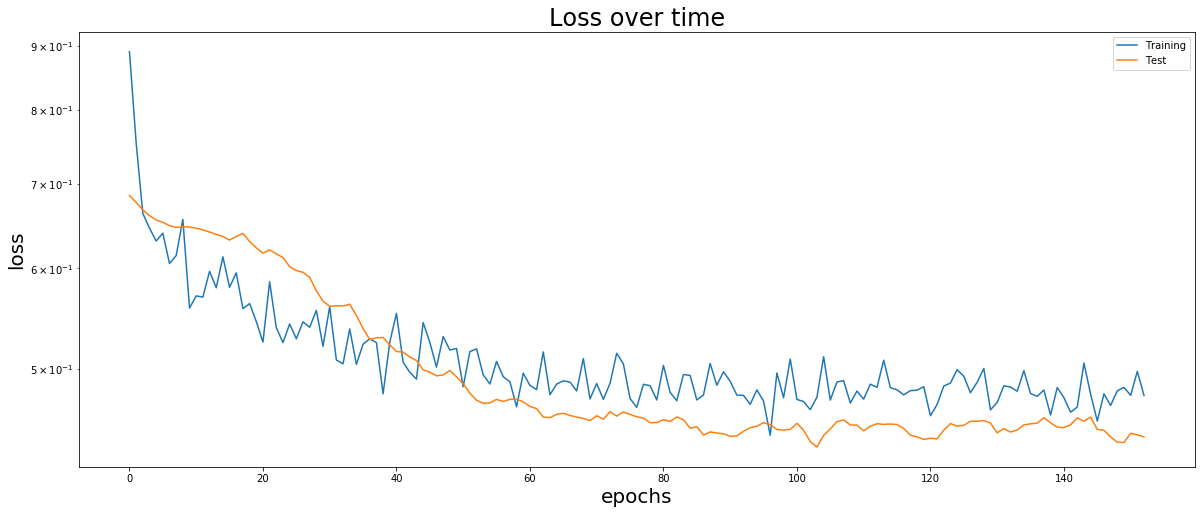

In [68]:
START_EPOCHE = 0
END_EPOCHE = -1

plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title('Loss over time')

plt.plot(history.history['loss'][START_EPOCHE:END_EPOCHE]);
plt.plot(history.history['val_loss'][START_EPOCHE:END_EPOCHE]);

plt.legend(['Training', 'Test']);

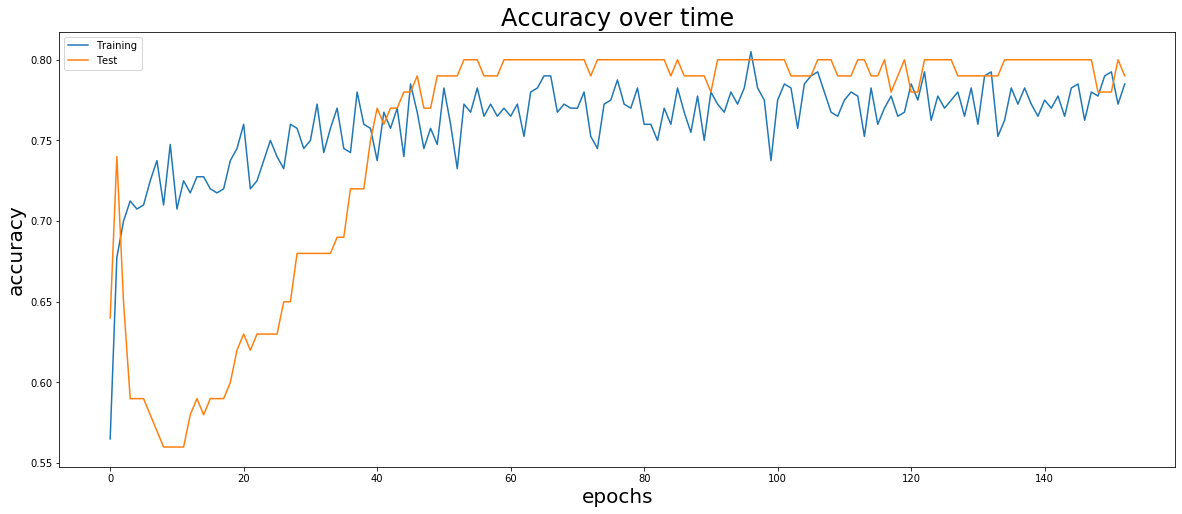

In [69]:
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.title('Accuracy over time')

plt.plot(history.history['accuracy'][START_EPOCHE:END_EPOCHE])
plt.plot(history.history['val_accuracy'][START_EPOCHE:END_EPOCHE])

plt.legend(['Training', 'Test']);

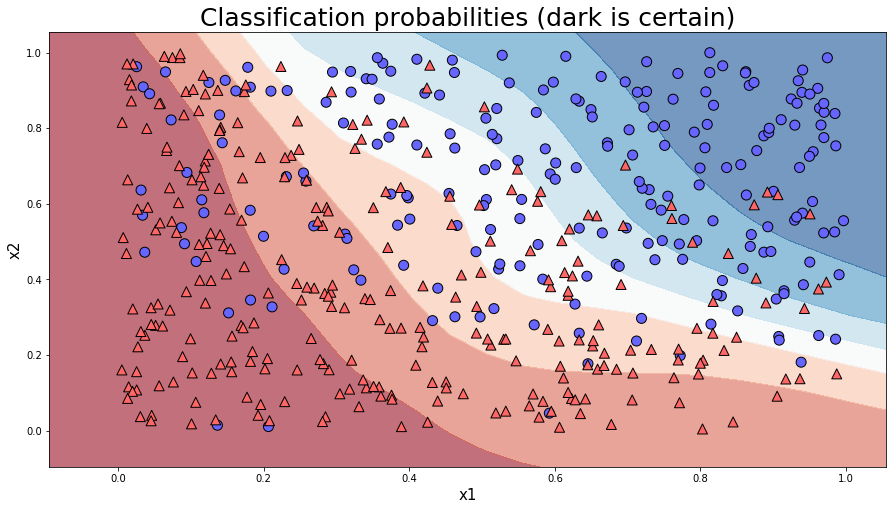

In [70]:
plotPrediction(model, X[:, 0], X[:, 1], 
               dim_1_label, dim_2_label, y,
                title="Classification probabilities (dark is certain)");

# Approach VI: Self-Normalizing Neural Networks 

***intuition: like dropout, but normalization is done as part of the activation function***

Self-Normalizing Neural Networks (https://arxiv.org/abs/1706.02515)
* https://www.tensorflow.org/api_docs/python/tf/keras/activations/selu
* https://www.tensorflow.org/api_docs/python/tf/keras/initializers/lecun_normal
* https://www.tensorflow.org/api_docs/python/tf/keras/layers/AlphaDropout  

https://towardsdatascience.com/selu-make-fnns-great-again-snn-8d61526802a9

In [71]:
%%time 
 
EPOCHS=1000    

dropout = 0.3

random_seed = 42

optimizer = tf.keras.optimizers.Adam()     

from tensorflow.keras.layers import Dense, AlphaDropout
    
model = tf.keras.Sequential()

model.add(Dense(units=100, input_dim=2, activation='selu', kernel_initializer=tf.initializers.lecun_normal(random_seed)))
model.add(AlphaDropout(dropout))

model.add(Dense(units=100, activation='selu', kernel_initializer=tf.initializers.lecun_normal(random_seed)))
model.add(AlphaDropout(dropout))

model.add(Dense(units=100, activation='selu', kernel_initializer=tf.initializers.lecun_normal(random_seed)))
model.add(AlphaDropout(dropout))

model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer=optimizer,
             metrics=['accuracy'])

PATIENCE = 100
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=PATIENCE)

history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=EPOCHS, 
                    callbacks=[early_stopping_callback, KerasLearningCurve()],
                    # callbacks=[KerasLearningCurve()],
                    verbose=0)

CPU times: user 27.5 s, sys: 2.19 s, total: 29.7 s
Wall time: 23.2 s


In [72]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=0)
loss, accuracy

(0.6152442240715027, 0.78)

In [73]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
loss, accuracy

(0.4320545816421509, 0.79)

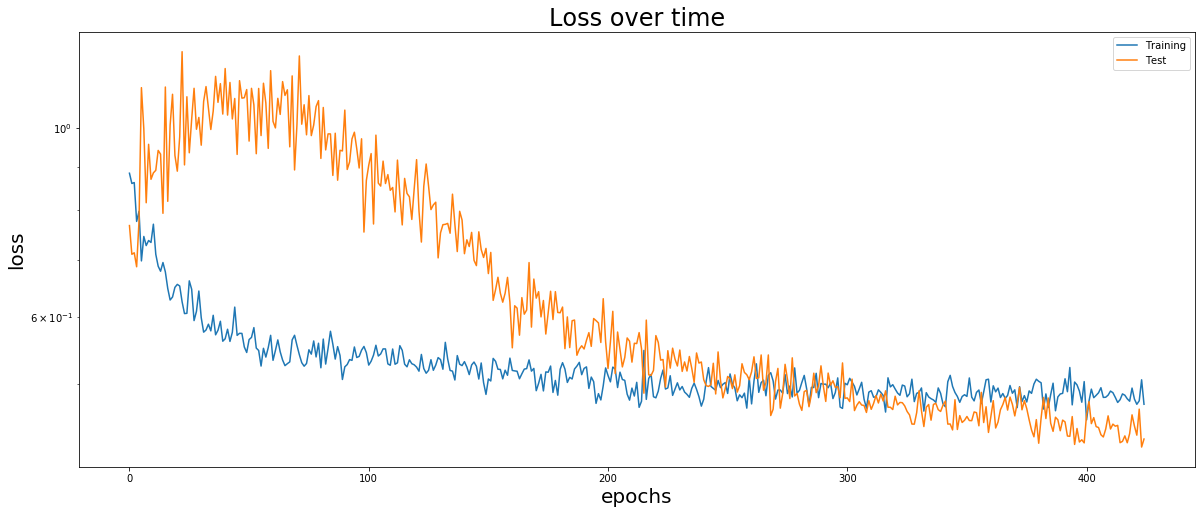

In [74]:
START_EPOCHE = 0
END_EPOCHE = -1

plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title('Loss over time')

plt.plot(history.history['loss'][START_EPOCHE:END_EPOCHE]);
plt.plot(history.history['val_loss'][START_EPOCHE:END_EPOCHE]);

plt.legend(['Training', 'Test']);

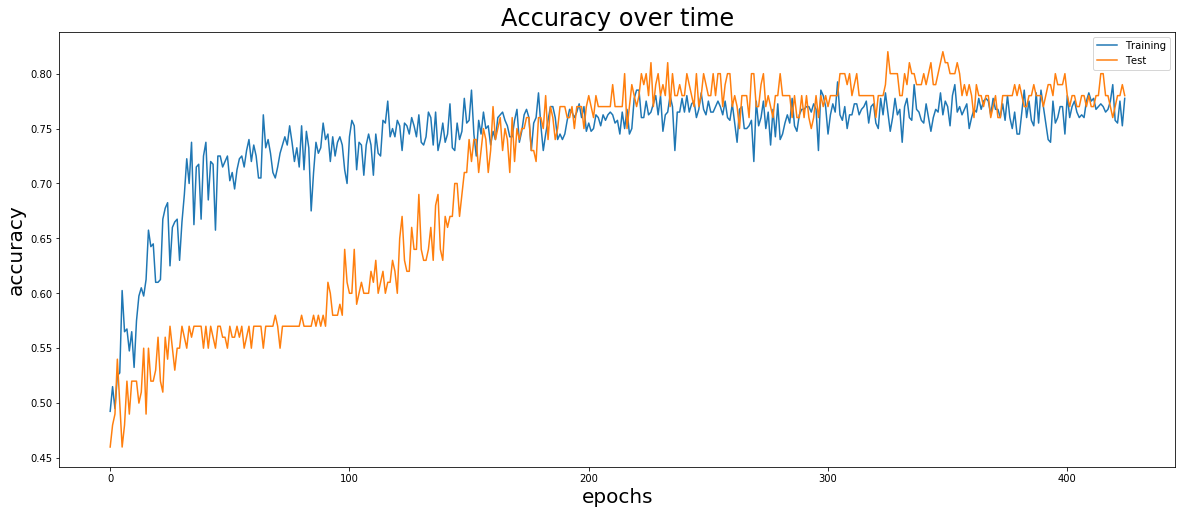

In [75]:
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.title('Accuracy over time')

plt.plot(history.history['accuracy'][START_EPOCHE:END_EPOCHE])
plt.plot(history.history['val_accuracy'][START_EPOCHE:END_EPOCHE])

plt.legend(['Training', 'Test']);

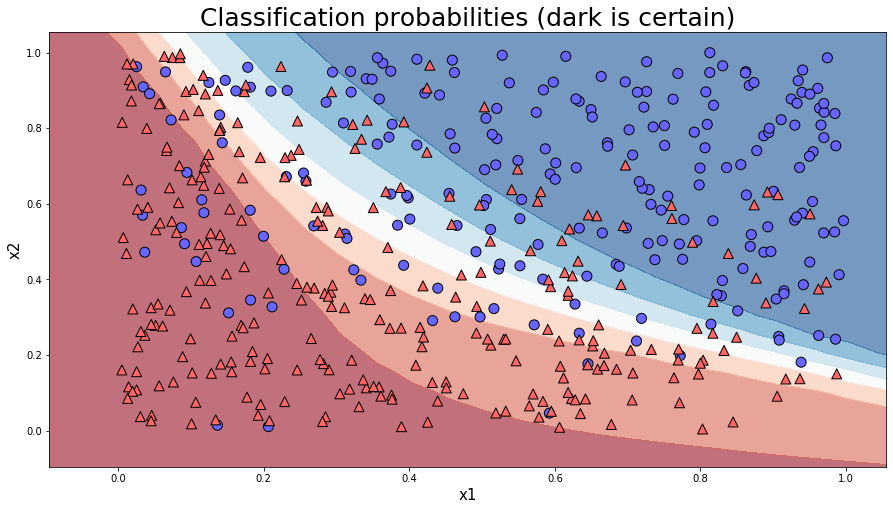

In [76]:
plotPrediction(model, X[:, 0], X[:, 1], 
               dim_1_label, dim_2_label, y,
                title="Classification probabilities (dark is certain)");